# Modeling differential expression between cell types in single cell RNA-seq data 

In order to simulate a **mixture** of cell types in single cell RNA-seq, we must first accurately model differential expression between cell types. Here, we explore and compare various models for doing so using externally and internally-annotated single cell RNA-seq data. 

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sc
import theano
import theano.tensor as tt
import copy
import feather
import re

import matplotlib.pyplot as plt
import statsmodels.stats.stattools
import statsmodels.graphics.gofplots

%matplotlib inline

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Data description

We consider the following datasets:

* 10x Genomics: 68k PBMCs
* HGSC: 5' GE from VOA11543SA (a particularly good sample with lots of cells)

Cell type assignments in the 68k PBMC data were annotated in XXXX, and our data was annotated with CellAssign (selecting cells with >90% probability for that given cell type). 

In [2]:
def get_logfcs_comparison(df, type1, type2):
    type2 = re.sub("[ \+\\/]", ".", type2)
    return(np.array(df[df.cluster == type1]["logFC." + type2]))

pbmc_markers = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/pbmc68k_markers.feather')
pbmc_null_logfcs = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/pbmc_68k_normal_logfcs.feather')

voa11543sa_markers = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/VOA11543SA_markers.feather')
voa11543sa_null_logfcs = feather.read_dataframe('/datadrive/projects/cellassign-paper/intermediates/bayesian_deprob/VOA11543SA_normal_logfcs.feather')

# Models


## null

See below. We fit the null model to bootstrap resamples. 

In [5]:
def run_null_model(nulls, iter_count = 2000, tune_iters = 2000):
    with pm.Model() as model:
        sd_null = pm.Gamma('sd_null', alpha = .1, beta = 1.)
        b_null = pm.Gamma('b_null', alpha = 1., beta = .1)
        
        dispersed_prob = pm.Beta('dispersed_prob', alpha = 1., beta = 1.)

        pm.Mixture('null',
                  comp_dists = [pm.Normal.dist(mu = 0., sd = sd_null),
                               pm.Laplace.dist(mu = 0., b = b_null)],
                  w = tt.as_tensor([1.-dispersed_prob, dispersed_prob]),
                  observed = nulls)

        pm.Deterministic('log_prob', model.logpt)

        trace = pm.sample(iter_count, tune = tune_iters, chains = 4)
        ppc = pm.sample_ppc(trace, samples=iter_count, model=model)
    
    return({'trace': trace, 'ppc': ppc})


## `splatter`

The current gold-standard, the `splatter` model for simulating synthetic single cell RNA-seq data (see https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1305-0), generates data for multiple cell populations as follows:

1. Generate $C$ populations at relative proportions $\theta$
2. $de\_prob_{i}$ genes are differentially expressed in population $i$ (compared to baseline)
3. If a gene is differentially expressed:
    * its fold change, equivalent to $\exp(\delta_{gc})$ from the `CellAssign` model, is drawn from $\text{Lognormal}(\mu_{i}, \sigma_{i})$, where $\mu_{i} > 0$
    * a certain proportion of DE'd genes (`down_prob`) are drawn from a separate lognormal with mean $-\mu_i$ (and the same $\sigma_i$)
4. Otherwise, its fold change is set to 0
5. Counts are simulated from a negative binomial given these fold change values and the other `splatter` parameters

When drawing fold changes, it is entirely possible that a gene that's supposed to be upregulated (i.e. drawn from the lognormal with positive mean) gets a fold change of $< 1$. In this case, `splatter` uses the reciprocal of the fold change instead (or equivalently, the negative of the logFC). The same applies for upregulated genes that are supposed to be downregulated.

To model this we construct a bit of a perverse model in `pymc3` -- we consider logFC's instead, and draw the positive and negative components from an absolute value-transformed `Normal`. This isn't straightforward to do in `pymc3`, but since we can easily compute the cdf of any Gaussian and $\text{Normal}(\mu,\sigma)$ and $\text{Normal}(-\mu,\sigma)$ are reflections over 0, we can treat each absolute value-Gaussian as a mixture of 2 Gaussians, as follows:

In [4]:
def splatter_model(observations, nulls, null_sd, null_b, null_dispersed_prob, iter_count = 2000, tune_iters = 2000):
    with pm.Model() as model:
        # Probability of being a DE gene
        de_prob = pm.Uniform('de_prob', lower = 0., upper = 1.)

        # Probability of being downregulated
        down_prob = pm.Beta('down_prob', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for non-DE genes (learned from bootstrap resampling)
        mu_null = pm.Gamma('mu_null', alpha = 1., beta = 1.)
        sd_null = pm.Gamma('sd_null', alpha = 1., beta = 1.)

        # Mean and sd for Gaussian for DE genes
        mu_pos = pm.Lognormal('mu_pos', mu = 0., sd = 1.)
        mu_neg = pm.Lognormal('mu_neg', mu = 0., sd = 1.)

        sd = pm.Gamma('sd', alpha = 1., beta = 1.)
        
        dispersed_prob = null_dispersed_prob
        spike_component = pm.Normal.dist(mu = 0., sd = null_sd) 
        slab_component = pm.Laplace.dist(mu = 0., b = null_b)

        # Sample from Gaussian-Laplace mixture for null (spike-and-slab mixture)
        pm.Mixture('null',
                  comp_dists = [spike_component,
                               slab_component],
                  w = tt.as_tensor([1.-dispersed_prob, dispersed_prob]),
                  observed = nulls)

        null_component = pm.Normal.dist(mu = mu_null,
                                      sd = sd_null)
        

        pos_component = pm.Bound(pm.Normal, lower=0.).dist(mu=mu_pos, sd=sd)
        neg_component = pm.Bound(pm.Normal, upper=0.).dist(mu=-1*mu_neg, sd=sd)
        pos_component_abs = pm.Bound(pm.Normal, lower=0.).dist(mu=-1*mu_pos, sd=sd)
        neg_component_abs = pm.Bound(pm.Normal, upper=0.).dist(mu=mu_neg, sd=sd)
        
        cdf_pos = cdf(mu = mu_pos, sd = sd, value = 0.)
        cdf_neg = cdf(mu = -1*mu_neg, sd = sd, value = 0.)

        pm.Mixture('obs',
                  w = tt.as_tensor([(1.-de_prob) * (1.-dispersed_prob),
                                    (1.-de_prob) * dispersed_prob, 
                                    de_prob * (1.-down_prob) * (1.-cdf_pos), 
                                    de_prob * down_prob * cdf_neg,
                                    de_prob * (1.-down_prob) * cdf_pos, 
                                    de_prob * down_prob * (1.-cdf_neg)]),
                  comp_dists = [spike_component,
                                slab_component, 
                                pos_component, 
                                neg_component, 
                                pos_component_abs,
                                neg_component_abs],
                  observed = observations)

        pm.Deterministic('log_prob', model.logpt)

        trace = pm.sample(iter_count, tune = tune_iters, chains = 4)
        ppc = pm.sample_ppc(trace, samples=iter_count, model=model)
    
    return({'trace': trace, 'ppc': ppc})

## Our model

We modify the `splatter` method by considering the following generative process for **log**FC values:

We draw logFC values from the following mixture:

* A null component (set to have all probability mass at 0 for simulations; but fitted as a Gaussian + Laplace mixture to bootstrap-derived logFC's from real data)
* A positively-displaced component, $\text{StudentT}(\mu_{+,i}, \sigma_{+,i}, \nu_{+,i})$ bounded to be $\geq 0$
* A negatively-displaced component, $\text{StudentT}(\mu_{-,i}, \sigma_{-,i}, \nu_{-,i})$, bounded to be $\leq 0$

The rationale for this model comes from the observation that the `splatter` model does not appear to fit outlying logFC values well (underestimating them). This is particularly problematic for `CellAssign` because those outlying genes can serve as terrific marker genes.

In [7]:
def v2_model(observations, nulls, null_sd, null_b, null_dispersed_prob, iter_count = 2000, tune_iters = 2000):
    with pm.Model() as model:
        # Probability of being a DE gene
        de_prob = pm.Beta('de_prob', alpha = 1., beta = 5.)
        
        # Probability of being downregulated
        down_prob = pm.Beta('down_prob', alpha = 1., beta = 1.)
        
        dispersed_prob = null_dispersed_prob

        mu_pos = pm.Lognormal('mu_pos', mu = -3, sd = 1.)
        mu_neg = pm.Lognormal('mu_neg', mu = -3, sd = 1.) 
        sd_pos = pm.Gamma('sd_pos', alpha = 0.01, beta = 1.) 
        sd_neg = pm.Gamma('sd_neg', alpha = 0.01, beta = 1.) 
        nu_pos = pm.Gamma('nu_pos', alpha = 5., beta = 1.)
        nu_neg = pm.Gamma('nu_neg', alpha = 5., beta = 1.)
        
        spike_component = pm.Normal.dist(mu = 0., sd = null_sd)
        slab_component = pm.Laplace.dist(mu = 0., b = null_b)

        # Sample from Gaussian-Laplace mixture for null (spike-and-slab mixture)
        pm.Mixture('null',
                  comp_dists = [spike_component,
                               slab_component],
                  w = tt.as_tensor([1.-dispersed_prob, dispersed_prob]),
                  observed = nulls)
    
        pos_component = pm.Bound(pm.StudentT, lower = 0.).dist(mu = mu_pos, sd = sd_pos, nu = nu_pos)
        neg_component = pm.Bound(pm.StudentT, upper = 0.).dist(mu = -mu_neg, sd = sd_neg, nu = nu_neg)
    
        pm.Mixture('obs',
                  w = tt.as_tensor([(1.-de_prob) * (1.-dispersed_prob),
                                    (1.-de_prob) * dispersed_prob,
                                    de_prob * (1.-down_prob),
                                   de_prob * down_prob]),
                  comp_dists = [spike_component, slab_component, pos_component, neg_component],
                  observed = observations)


        pm.Deterministic('log_prob', model.logpt)
        
        for RV in model.basic_RVs:
            print(RV.name, RV.logp(model.test_point))

        trace = pm.sample(iter_count, tune = tune_iters, chains = 4)
        ppc = pm.sample_ppc(trace, samples=iter_count, model=model)
    
    return({'trace': trace, 'ppc': ppc})

# 68k PBMCs: naive CD4+ vs. naive CD8+

Our first comparison will be naive CD4+ T cells vs. naive CD8+ T cells from the 68k PBMC data. 

In [11]:
class1 = "Naive CD8+"
class2 = "Naive CD4+"

logfcs_diff = get_logfcs_comparison(pbmc_markers, class1, class2)
logfcs_same = np.array(pbmc_null_logfcs[(pbmc_null_logfcs['celltype'] == class1) & (pbmc_null_logfcs['permutation'] == 1)].logfc)

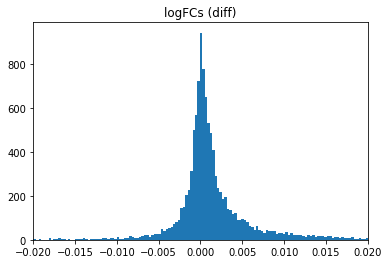

In [12]:
plt.hist(logfcs_diff, bins = 'auto') 
plt.title("logFCs (diff)")
#plt.yscale('log', nonposy='clip')
plt.xlim((-0.02, 0.02))
plt.show()

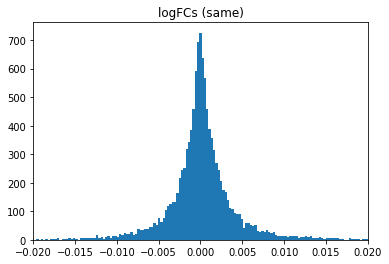

In [13]:
plt.hist(logfcs_same, bins = 'auto') 
plt.title("logFCs (same)")
#plt.yscale('log', nonposy='clip')
plt.xlim((-0.02, 0.02))
plt.show()

The bottom plot represents the null distribution of logFC's (using bootstrap resamples from naive CD8+'s), and the top plot shows the logFC's for all genes.

## Fitting null parameters

We first need to fit null parameters $\sigma$ (for the Normal component), $b$ (for the Laplace component), and `dispersed_prob` (the contribution of the Laplace component relative to the Normal one).

In [ ]:
pbmc_cd4_cd8_null = run_null_model(logfcs_same, iter_count=4000, tune_iters = 2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dispersed_prob, b_null, sd_null]
Sampling 4 chains:  33%|███▎      | 7945/24000 [00:45<00:56, 284.12draws/s]

In [ ]:
pm.traceplot(pbmc_cd4_cd8_null)